In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


# Drop filaname feature

In [9]:
df.drop('filename', axis=1, inplace=True)

# See the missing values

In [14]:
df.isnull().sum()

length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var                  0
mfcc9_mean    

### Observation: No missing value available

# Categorical Encoding

In [20]:
from sklearn.preprocessing import LabelEncoder

In [21]:
lb = LabelEncoder()
df['label'] = lb.fit_transform(df['label'])

# Model training

In [27]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# See the outliers

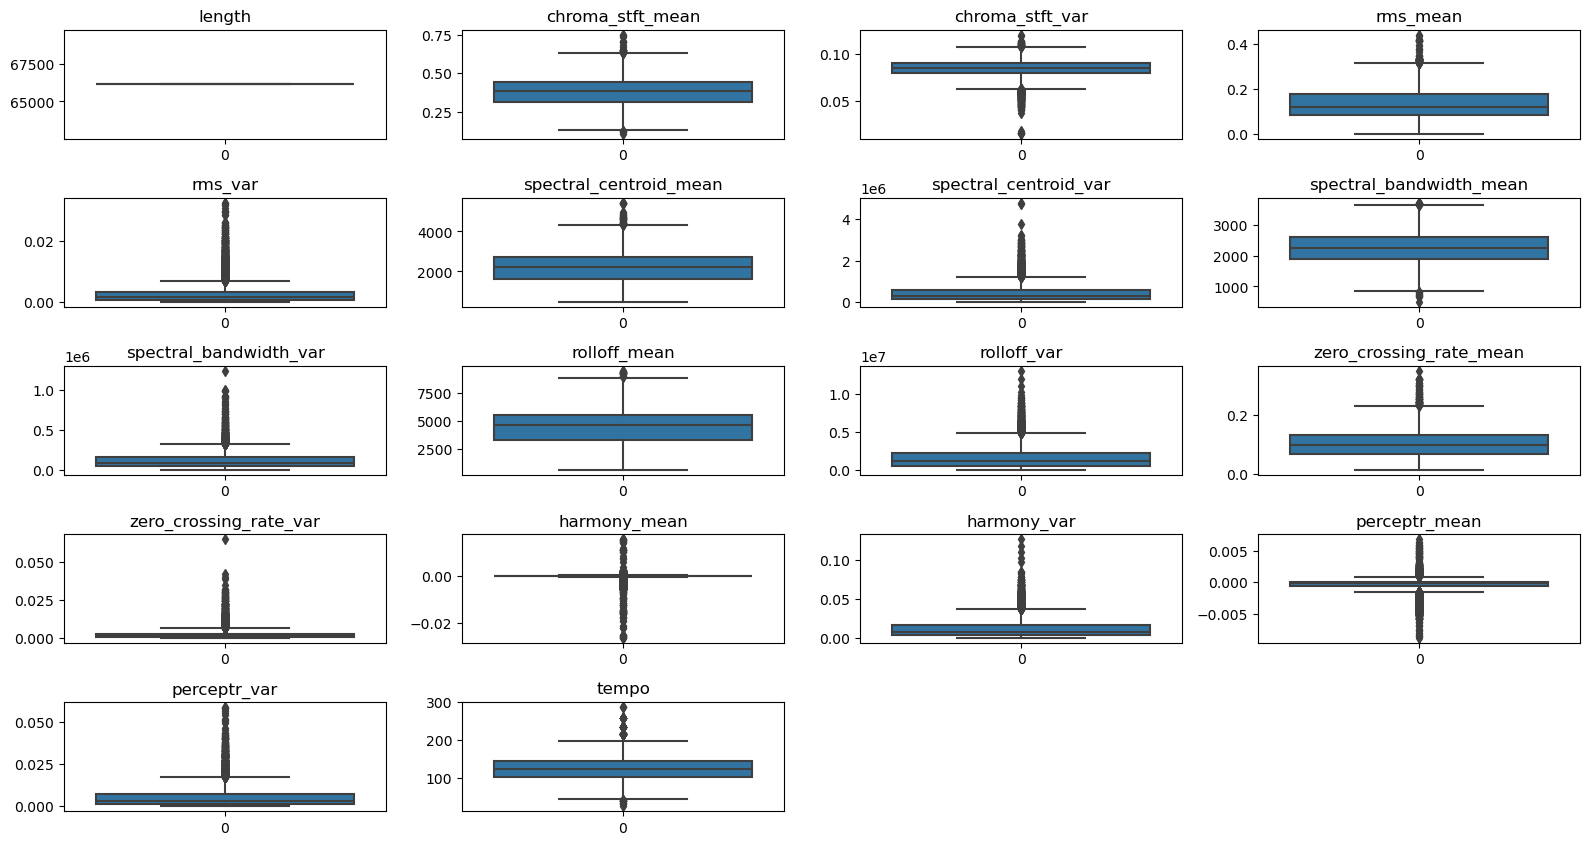

In [32]:
plt.figure(figsize=[16, 10])

lst = ['length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo']
for i, j in enumerate(lst):
    plt.subplot(6, 4, i+1)
    plt.title(j)
    sns.boxplot(data=df[j])
    plt.tight_layout()

# Fix the outliers

In [36]:
def fix_outlier(dataset, feature):
    iqr = dataset[feature].quantile(0.75) - dataset[feature].quantile(0.25)
    upper_border = dataset[feature].quantile(0.75) + (iqr*1.5)
    lower_border = dataset[feature].quantile(0.25) - (iqr*1.5)
    dataset[feature] = np.clip(dataset[feature], lower_border, upper_border)

for feature in X_train:
    fix_outlier(X_train, feature)
    fix_outlier(X_test, feature)

# Fix the skewed features

In [42]:
from sklearn.preprocessing import PowerTransformer

skewness = X_train.skew()
skewed_features = skewness[(skewness>1) | (skewness<-1)].index.tolist()
less_skewed_features = skewness[(skewness<=1) & (skewness>=-1)].index.tolist()

In [44]:
pt = PowerTransformer(method='yeo-johnson')
X_train[skewed_features]= pt.fit_transform(X_train[skewed_features])
X_test[skewed_features] = pt.transform(X_test[skewed_features])

# Apply standard scaler on less skewed features

In [49]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[less_skewed_features] = scaler.fit_transform(X_train[less_skewed_features])
X_test[less_skewed_features] = scaler.transform(X_test[less_skewed_features])

# Apply PCA

In [54]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [57]:
features_name = [f"pc{i}" for i in range(1, X_train.shape[1]+1)]

X_train= pd.DataFrame(X_train, columns=features_name)
X_test = pd.DataFrame(X_test, columns=features_name)

# Model Creating

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score

In [64]:
models = {
    'Logistic': LogisticRegression(),
    'SVC': SVC(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Ada Boost': AdaBoostClassifier(),
    'Gradient Boost': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier()
}

In [66]:
for i in range(len(models)):
    model = list(models.values())[i]
    model.fit(X_train, y_train)

    # Model Prediction
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Train data prediction
    train_ac = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    train_recall = recall_score(y_train, y_train_pred, average='macro')

    # Test data prediction
    test_ac = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    test_recall = recall_score(y_test, y_test_pred, average='macro')

    print(list(models.keys())[i])
    print('\t-Train accuracy score: ', train_ac)
    print('\t-Train f1 score: ', train_f1)
    print('\t-Train recall score: ', train_recall, '\n')

    print('\t-Test accuracy score: ', test_ac)
    print('\t-Test f1 score: ', test_f1)
    print('\t-Test recall score: ', test_recall)

    print('*'*15)

Logistic
	-Train accuracy score:  0.631701030927835
	-Train f1 score:  0.6275909779265157
	-Train recall score:  0.6317010309278351 

	-Test accuracy score:  0.6453162530024019
	-Test f1 score:  0.6348603791297333
	-Test recall score:  0.6454776315317123
***************
SVC
	-Train accuracy score:  0.856701030927835
	-Train f1 score:  0.8561637147299754
	-Train recall score:  0.856701030927835 

	-Test accuracy score:  0.8078462770216173
	-Test f1 score:  0.8053352797902612
	-Test recall score:  0.8072627068664039
***************
Naive Bayes
	-Train accuracy score:  0.5859536082474227
	-Train f1 score:  0.5809992706760183
	-Train recall score:  0.5859536082474226 

	-Test accuracy score:  0.588871096877502
	-Test f1 score:  0.5819802407740438
	-Test recall score:  0.588965462244934
***************
Decision Tree
	-Train accuracy score:  0.9992268041237113
	-Train f1 score:  0.9992267925675105
	-Train recall score:  0.9992268041237115 

	-Test accuracy score:  0.5912730184147318
	-Test f

# Hyperparameter tuning

In [69]:
param_grid_svc = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'degree': [2, 3, 4],  # Degree of polynomial kernel (only relevant for 'poly')
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'coef0': [0.0, 0.1, 0.5, 1],  # Independent term in 'poly' and 'sigmoid' kernels
}

param_grid_rf = {
    'n_estimators': [50, 100, 200, 500],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples in a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider for splits
    'bootstrap': [True, False],  # Whether to use bootstrapping
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 11, 15],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weighting of neighbors
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
    'p': [1, 2]  # Power parameter for Minkowski distance (1=Manhattan, 2=Euclidean)
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200, 500],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Step size shrinkage
    'max_depth': [3, 5, 7, 10],  # Maximum depth of trees
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples per boosting round
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features for each tree
    'gamma': [0, 0.1, 0.2, 0.3],  # Minimum loss reduction required for a split
    'reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization
    'reg_lambda': [0, 0.1, 0.5, 1]  # L2 regularization
}

In [73]:
random_cv_model = [
    ('SVC', SVC(), param_grid_svc),
    ('RandomForest', RandomForestClassifier(), param_grid_rf),
    ('KNN', KNeighborsClassifier(), param_grid_knn),
    ('XGBoost', XGBClassifier(), param_grid_xgb)
]

In [75]:
from sklearn.model_selection import RandomizedSearchCV

model_params = {}
for name, model, param in random_cv_model:
    randomcv = RandomizedSearchCV(estimator=model, param_distributions=param,
                                  n_iter=100,
                                  cv=3, 
                                  verbose=2, 
                                  n_jobs=-1)
    randomcv.fit(X_train, y_train)
    model_params[name] = randomcv.best_params_

    for name in model_params:
        print(f"---------- Best Params {name} ----------")
        print(model_params[name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
---------- Best Params SVC ----------
{'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'coef0': 0.1, 'C': 10}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
---------- Best Params SVC ----------
{'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'coef0': 0.1, 'C': 10}
---------- Best Params RandomForest ----------
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Fitting 3 folds for each of 60 candidates, totalling 180 fits
---------- Best Params SVC ----------
{'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'coef0': 0.1, 'C': 10}
---------- Best Params RandomForest ----------
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
---------- Best Params KNN ----------
{'weights': 'distance', 'p': 1, 'n_neighbors': 3, 'metric': 'manhattan'}
Fitting 3 folds for each 

In [77]:
models = {
    'SVC': SVC(kernel= 'rbf', gamma= 0.1, degree= 2, coef0= 0.1, C= 10),
    
    'KNN': KNeighborsClassifier(weights= 'distance', p= 1, n_neighbors= 3, metric= 'manhattan'),
    
    'Random Forest': RandomForestClassifier(n_estimators= 200, min_samples_split= 2, min_samples_leaf= 1, max_features= 'log2',
                                            max_depth= None, bootstrap= False),
    
    'XGBoost': XGBClassifier(subsample= 0.6, reg_lambda= 1, reg_alpha= 0, n_estimators= 500, 
                             max_depth= 10, learning_rate= 0.1, gamma= 0, colsample_bytree= 0.8)
}

In [79]:
for i in range(len(models)):
    model = list(models.values())[i]
    model.fit(X_train, y_train)

    # Model Prediction
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Train data prediction
    train_ac = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    train_recall = recall_score(y_train, y_train_pred, average='macro')

    # Test data prediction
    test_ac = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    test_recall = recall_score(y_test, y_test_pred, average='macro')

    print(list(models.keys())[i])
    print('\t-Train accuracy score: ', train_ac)
    print('\t-Train f1 score: ', train_f1)
    print('\t-Train recall score: ', train_recall, '\n')

    print('\t-Test accuracy score: ', test_ac)
    print('\t-Test f1 score: ', test_f1)
    print('\t-Test recall score: ', test_recall)

    print('*'*15)

SVC
	-Train accuracy score:  0.9992268041237113
	-Train f1 score:  0.9992267925675105
	-Train recall score:  0.9992268041237115 

	-Test accuracy score:  0.8943154523618895
	-Test f1 score:  0.8936090345905641
	-Test recall score:  0.8937587883221655
***************
KNN
	-Train accuracy score:  0.9992268041237113
	-Train f1 score:  0.9992267925675105
	-Train recall score:  0.9992268041237115 

	-Test accuracy score:  0.8698959167333867
	-Test f1 score:  0.8686856433451673
	-Test recall score:  0.8687883561200331
***************
Random Forest
	-Train accuracy score:  0.9992268041237113
	-Train f1 score:  0.9992267925675105
	-Train recall score:  0.9992268041237115 

	-Test accuracy score:  0.8402722177742193
	-Test f1 score:  0.8382995677488786
	-Test recall score:  0.8396499804466513
***************
XGBoost
	-Train accuracy score:  0.9992268041237113
	-Train f1 score:  0.999226802839706
	-Train recall score:  0.9992268041237112 

	-Test accuracy score:  0.8198558847077662
	-Test f1 sco